In [1]:
import torch
import torch.nn as nn
from torch import optim 
from torch.distributions import Categorical
import gym
from tqdm import tqdm
from collections import deque
from random import sample
import numpy as np
import matplotlib.pyplot as plt

/Users/khela/miniconda3/envs/dqn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_all_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
device = "cuda" if torch.cuda.is_available() else "cpu"
set_all_seeds(42)

In [3]:
env = gym.make('LunarLander-v2')
obs_space = env.observation_space.shape[0]
act_space = env.action_space.n

In [186]:
MAX_STEPS = 300000
BUFFER_WARMUP = 500
GAMMA = 0.99
LEARNING_RATE = 1e-3
EPSILON_EXP = 0.998
EPSILON_LIN = 0.001
TARGET_UPDATE = 200
BATCH_SIZE = 32

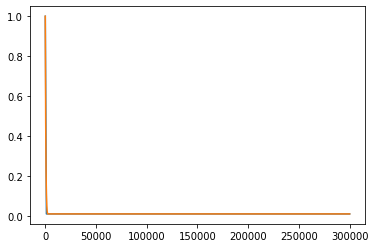

In [187]:
exp_epsilons = [max(0.01, 1 * EPSILON_EXP**i) for i in range(MAX_STEPS)]
lin_epsilons = [max(0.01, 1 - EPSILON_LIN * i) for i in range(MAX_STEPS)]
    
plt.plot(lin_epsilons)
plt.plot(exp_epsilons)

In [188]:
class ReplayBuffer():
    def __init__(self, length, device):
        self.length = length
        self.device = device
        self.observations = deque(maxlen=length)
        self.actions = deque(maxlen=length)
        self.rewards = deque(maxlen=length)
        self.dones = deque(maxlen=length)
        self.next_observations = deque(maxlen=length)
        
    def add_experience(self, obs, reward, action, done, next_obs):
        self.observations.append(torch.from_numpy(obs).to(self.device))
        self.actions.append(torch.tensor(action).to(device))
        self.rewards.append(torch.tensor(reward).to(device))
        self.dones.append(torch.tensor(done).to(device))
        self.next_observations.append(torch.from_numpy(next_obs).to(self.device))
        
    def sample_experience(self, size):
        indicies = sample(range(len(self.observations)), size)
        sampled_observations = torch.stack([self.observations[i] for i in indicies])
        sampled_actions = torch.stack([self.actions[i] for i in indicies])
        sampled_rewards = torch.stack([self.rewards[i] for i in indicies])
        sampled_dones = torch.stack([self.dones[i] for i in indicies])
        sampled_next_observations = torch.stack([self.next_observations[i] for i in indicies])
        return sampled_observations, sampled_actions, sampled_rewards, sampled_dones, sampled_next_observations, 

In [189]:
class DQN(nn.Module):
    def __init__(self, obs_space, act_space, device):
        super(DQN, self).__init__()
        self.obs_space = obs_space
        self.act_space = act_space
        self.device = device
        
        self.backbone = nn.Sequential(
            nn.Linear(self.obs_space, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.act_space),
        ).to(self.device)
        

    def forward(self, obs):
        obs = obs if torch.is_tensor(obs) else torch.from_numpy(obs).to(self.device)
        obs = obs.view(-1, self.obs_space)
        logit = self.backbone(obs)
        return logit
    
    @torch.no_grad()
    def get_action(self, obs, epsilon):
        if torch.rand(1) < epsilon:
            return torch.randint(0, self.act_space, (1,))
        else:
            obs = torch.from_numpy(obs).view(-1, self.obs_space).to(self.device)
            qs = self.forward(obs)
            return torch.argmax(qs, dim=1)

In [190]:
dqn = DQN(obs_space, act_space, device)
target_dqn = DQN(obs_space, act_space, device)
target_dqn.load_state_dict(dqn.state_dict())

buffer = ReplayBuffer(100000, device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=dqn.parameters(), lr=LEARNING_RATE)

In [191]:
obs = env.reset()
done = False
reward = 0
ep_rews = []
losses = []
ep_rew = 0
for step in tqdm(range(MAX_STEPS)):
    action = dqn.get_action(obs, exp_epsilons[step]).item()
    next_obs, reward, done, _ = env.step(action)
    buffer.add_experience(obs, reward, action, done, next_obs)
    obs = next_obs
        
    ep_rew += reward
    
    if done:
        obs = env.reset()
        done = False
        reward = 0
        ep_rews.append(ep_rew)
        ep_rew = 0
      
    if step >= BUFFER_WARMUP:
        _observations, _actions, _rewards, _dones, _next_observations = buffer.sample_experience(BATCH_SIZE)
        y = _dones * _rewards + ((1 - _dones.float()) * (_rewards+ GAMMA * torch.max(target_dqn.forward(_next_observations), dim=1).values))
        y_ = torch.gather(dqn.forward(_observations), 1, _actions.view(-1, 1)).view(-1)
        loss = loss_fn(y_, y.float().detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        
    if step % TARGET_UPDATE == 0:
        target_dqn.load_state_dict(dqn.state_dict())

100%|██████████| 300000/300000 [34:09<00:00, 146.39it/s] 


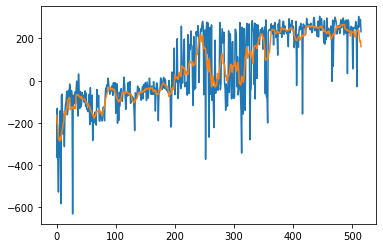

In [192]:
plt.plot(ep_rews)
plt.plot(np.convolve(np.array(ep_rews), np.ones(10), 'same') / 10)

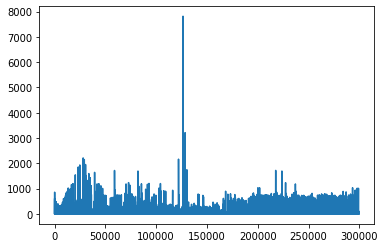

In [193]:
plt.plot(losses)